## 9. Solutions

Open after you try Section 8.

### Solution 8.1

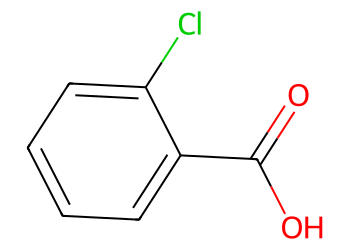

rings: <rdkit.rdBase._vectclass std::vector<int,class std::allocator<int> > object at 0x000002B4A3A718C0>
bond 0 0 - 1 order 2
bond 1 1 - 2 order 1
bond 2 1 - 3 order 1
bond 3 3 - 4 order 1
bond 4 4 - 5 order 1
bond 5 5 - 6 order 1
bond 6 6 - 7 order 1
bond 7 7 - 8 order 1
bond 8 8 - 9 order 1
bond 9 8 - 3 order 1


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

smi = "O=C(O)c1ccccc1Cl"

mol = Chem.MolFromSmiles(smi)
display(Draw.MolToImage(mol, size=(350, 250), includeAtomNumbers=True))

num_rings = Chem.GetSSSR(mol)
print("rings:", num_rings)

for b in mol.GetBonds():
    print("bond", b.GetIdx(), b.GetBeginAtomIdx(), "-", b.GetEndAtomIdx(), "order", int(b.GetBondTypeAsDouble()))

### Solution 8.2

In [2]:
import pandas as pd
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

names = ["caffeine", "acetaminophen", "ibuprofen"]
rows = []
for nm in names:
    info = pubchem_smiles_by_name(nm)
    smi = info["smiles"]
    m = Chem.MolFromSmiles(smi)
    rows.append({
        "name": nm,
        "smiles": smi,
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "HBD": rdMolDescriptors.CalcNumHBD(m),
        "HBA": rdMolDescriptors.CalcNumHBA(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m)
    })

pd.DataFrame(rows)

NameError: name 'pubchem_smiles_by_name' is not defined

### Solution 8.3

In [ ]:
find = Chem.MolFromSmiles("Cl")
put  = Chem.MolFromSmiles("F")
mol  = Chem.MolFromSmiles("Clc1ccc(cc1)C(=O)O")
out  = Chem.ReplaceSubstructs(mol, find, put, replaceAll=True)[0]
print(Chem.MolToSmiles(out))
Draw.MolToImage(out, size=(350, 250))

### Solution 8.4

In [ ]:
mol = Chem.MolFromSmiles("c1ccccc1")
em = Chem.EditableMol(mol)

idx_C = em.AddAtom(Chem.Atom("C"))
idx_H1 = em.AddAtom(Chem.Atom("H"))
idx_H2 = em.AddAtom(Chem.Atom("H"))
idx_H3 = em.AddAtom(Chem.Atom("H"))

em.AddBond(2, idx_C, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H1, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H2, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H3, order=Chem.BondType.SINGLE)

mol2 = em.GetMol()
Chem.SanitizeMol(mol2)
Draw.MolToImage(mol2, size=(350, 250), includeAtomNumbers=True)

### Solution 8.5

In [ ]:
mixed = ["446157", "2244", "CCO", "482752", "c1ccccc1"]

for q in mixed:
    if q.isdigit():  # looks like CID
        info = pubchem_smiles_by_cid(int(q))
        smi, cid = info["smiles"], info["cid"]
    elif Chem.MolFromSmiles(q):  # parses as SMILES
        smi, cid = q, None
    else:  # treat as name
        info = pubchem_smiles_by_name(q)
        smi, cid = info["smiles"], info["cid"]
    print(f"input={q} CID={cid} SMILES={smi}")
    mol = Chem.MolFromSmiles(smi)
    display(Draw.MolToImage(mol, size=(260, 200)))